# Densenet Architecture Implementation

Tham khảo : 
1. https://amaarora.github.io/posts/2020-08-02-densenets.html#densenet-architecture-implementation
2. https://github.com/pytorch/vision/blob/main/torchvision/models/densenet.py

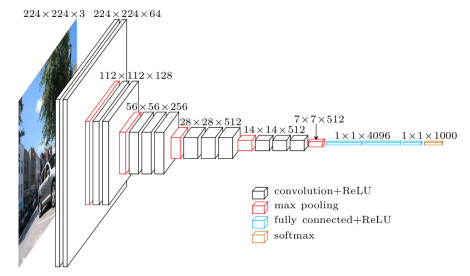
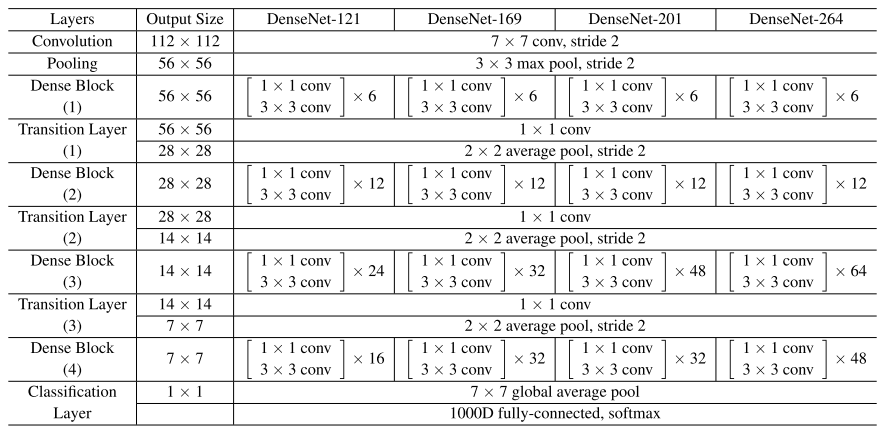

In [51]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models
from imutils import paths
import pandas as pd
import random
from sklearn.preprocessing import LabelEncoder
from keras.preprocessing.image import img_to_array
from keras.applications import imagenet_utils
from keras.preprocessing.image import load_img
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report , confusion_matrix
import os
import tensorflow as tf
from keras.callbacks import ModelCheckpoint
import matplotlib.pyplot as plt
import seaborn as sns

##### DenseNet

In [3]:
def _DenseLayer(num_input_features, growth_rate, bn_size, drop_rate, memory_efficient=False):
    class _DenseLayerClass(layers.Layer):
        def __init__(self):
            super(_DenseLayerClass, self).__init__()
            self.norm1 = layers.BatchNormalization()
            self.relu1 = layers.ReLU()
            self.conv1 = layers.Conv2D(bn_size * growth_rate, kernel_size=1, strides=1, padding='valid', use_bias=False)

            self.norm2 = layers.BatchNormalization()
            self.relu2 = layers.ReLU()
            self.conv2 = layers.Conv2D(growth_rate, kernel_size=3, strides=1, padding='same', use_bias=False)

            self.drop_rate = drop_rate
            self.memory_efficient = memory_efficient

        def call(self, inputs):
            prev_features = inputs

            if self.memory_efficient and np.any([tf.is_tensor(tensor) for tensor in prev_features]):
                raise Exception("Memory Efficient not supported in Keras")

            concated_features = tf.concat(prev_features, axis=-1)
            bottleneck_output = self.conv1(self.relu1(self.norm1(concated_features)))
            new_features = self.conv2(self.relu2(self.norm2(bottleneck_output)))

            if self.drop_rate > 0:
                new_features = layers.Dropout(self.drop_rate)(new_features)

            return new_features

    return _DenseLayerClass()


class _DenseBlock(layers.Layer):
    def __init__(self, num_layers, num_input_features, bn_size, growth_rate, drop_rate, memory_efficient=False):
        super(_DenseBlock, self).__init__()
        self.layers_list = []
        for i in range(num_layers):
            layer = _DenseLayer(num_input_features=num_input_features + i * growth_rate,
                                growth_rate=growth_rate,
                                bn_size=bn_size,
                                drop_rate=drop_rate,
                                memory_efficient=memory_efficient)
            self.layers_list.append(layer)

    def call(self, inputs):
        features = [inputs]
        for layer in self.layers_list:
            new_features = layer(features)
            features.append(new_features)
        return tf.concat(features, axis=-1)


class _Transition(layers.Layer):
    def __init__(self, num_input_features, num_output_features):
        super(_Transition, self).__init__()
        self.norm = layers.BatchNormalization()
        self.relu = layers.ReLU()
        self.conv = layers.Conv2D(num_output_features, kernel_size=1, strides=1, padding='valid', use_bias=False)
        self.pool = layers.AveragePooling2D(pool_size=(2, 2), strides=2)

    def call(self, inputs):
        x = self.norm(inputs)
        x = self.relu(x)
        x = self.conv(x)
        return self.pool(x)


def DenseNet(growth_rate=32, block_config=(6, 12, 24, 16), num_init_features=64, bn_size=4, drop_rate=0,
             num_classes=1000, memory_efficient=False):
    inputs = tf.keras.Input(shape=(None, None, 3))

    x = layers.Conv2D(num_init_features, kernel_size=7, strides=2, padding='same', use_bias=False)(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    x = layers.MaxPooling2D(pool_size=(3, 3), strides=2, padding='same')(x)

    num_features = num_init_features
    for i, num_layers in enumerate(block_config):
        block = tf.keras.Sequential(name=f'denseblock{i+1}')
        for j in range(num_layers):
            block.add(_DenseLayer(num_input_features=num_features + j * growth_rate,
                                  growth_rate=growth_rate,
                                  bn_size=bn_size,
                                  drop_rate=drop_rate,
                                  memory_efficient=memory_efficient))
        x = block(x)
        num_features = num_features + num_layers * growth_rate
        if i != len(block_config) - 1:
            trans = _Transition(num_input_features=num_features, num_output_features=num_features // 2)
            x = trans(x)
            num_features = num_features // 2

    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    x = layers.GlobalAveragePooling2D()(x)

    outputs = layers.Dense(num_classes, activation='softmax')(x)

    model = models.Model(inputs, outputs)

    return model

# Usage example:
model = DenseNet()


#### Tiền xử lí dữ liệu 

In [4]:
# Lấy các đường dẫn đến ảnh.
# image_path = list(paths.list_images('data/dogs-vs-cats/train/train'))
image_path = list(paths.list_images('data_5000/dogs-vs-cats'))

# Đổi vị trí ngẫu nhiên các đường dẫn ảnh
random.shuffle(image_path)

# Chỉ lấy 5000 dòng đầu tiên (5000 ảnh)
# image_path = image_path[:5000]
# print(image_path)

In [5]:
labels = [p.split(os.path.sep)[-1] for p in image_path]
labels = [label.split('.')[-3] for label in labels]
print(labels)
# Chuyển tên các loài hoa thành số
le = LabelEncoder()
labels = le.fit_transform(labels)
print(labels)

['cat', 'dog', 'dog', 'dog', 'cat', 'cat', 'cat', 'dog', 'cat', 'dog', 'dog', 'cat', 'cat', 'dog', 'dog', 'cat', 'dog', 'dog', 'dog', 'dog', 'cat', 'cat', 'dog', 'dog', 'dog', 'dog', 'dog', 'dog', 'cat', 'cat', 'dog', 'cat', 'cat', 'cat', 'cat', 'dog', 'dog', 'dog', 'dog', 'cat', 'cat', 'dog', 'cat', 'dog', 'dog', 'dog', 'cat', 'dog', 'cat', 'dog', 'cat', 'cat', 'cat', 'dog', 'dog', 'cat', 'cat', 'cat', 'dog', 'dog', 'dog', 'cat', 'dog', 'cat', 'cat', 'cat', 'dog', 'dog', 'dog', 'cat', 'cat', 'cat', 'cat', 'dog', 'dog', 'dog', 'dog', 'cat', 'cat', 'dog', 'dog', 'cat', 'dog', 'cat', 'dog', 'cat', 'dog', 'dog', 'dog', 'cat', 'cat', 'dog', 'cat', 'cat', 'cat', 'dog', 'dog', 'cat', 'dog', 'cat', 'cat', 'cat', 'cat', 'dog', 'cat', 'dog', 'cat', 'cat', 'cat', 'dog', 'cat', 'cat', 'cat', 'cat', 'dog', 'dog', 'dog', 'dog', 'dog', 'dog', 'dog', 'cat', 'cat', 'cat', 'dog', 'dog', 'dog', 'cat', 'dog', 'dog', 'dog', 'cat', 'dog', 'dog', 'dog', 'dog', 'dog', 'dog', 'dog', 'dog', 'dog', 'cat', 'cat'

In [6]:
# Load ảnh và resize về đúng kích thước mà VGG 16 cần là (224,224)
list_image = []
for (j, imagePath) in enumerate(image_path):
    # Load ảnh và resize về kích thước (224, 224)
    image = load_img(imagePath, target_size=(224, 224))
    
    # Chuyển ảnh thành mảng numpy
    image = img_to_array(image)
    
    # Mở rộng chiều của mảng numpy
    image = np.expand_dims(image, 0)
    
    # Tiền xử lý ảnh theo tiêu chuẩn của mô hình VGG16
    image = imagenet_utils.preprocess_input(image)
    
    # Thêm ảnh đã tiền xử lý vào danh sách
    list_image.append(image)
    
# Chuyển danh sách các ảnh thành mảng numpy một chiều
list_image = np.vstack(list_image)

In [ ]:
print(list_image)

In [7]:
X_train, X_test, y_train, y_test = train_test_split(list_image, labels, test_size=0.2, random_state=42)

#### Xây dựng model

In [8]:
# Tạo một mô hình DenseNet
model = DenseNet()

# Tạo đối tượng optimizer
optimizer = tf.keras.optimizers.Adam()

save_best_only = True
checkpoint = ModelCheckpoint('models/model-{epoch:03d}.keras',  
                             monitor='val_loss',
                             verbose=1,
                             save_best_only=save_best_only,
                             mode='auto')

# Xây dựng quy trình huấn luyện
model.compile(optimizer=optimizer,
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# Huấn luyện mô hình với dữ liệu đã chuẩn bị
H = model.fit(X_train, y_train, epochs=10, batch_size=32, validation_split=0.2, callbacks=[checkpoint])

Epoch 1/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 223s 2s/step - accuracy: 0.4304 - loss: 5.8361 - val_accuracy: 0.5275 - val_loss: 4.4988
Epoch 2/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 200s 2s/step - accuracy: 0.5096 - loss: 1.6903 - val_accuracy: 0.5275 - val_loss: 1.6497
Epoch 3/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 191s 2s/step - accuracy: 0.5069 - loss: 0.7913 - val_accuracy: 0.5275 - val_loss: 0.9385
Epoch 4/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 187s 2s/step - accuracy: 0.4970 - loss: 0.7330 - val_accuracy: 0.5275 - val_loss: 0.7613
Epoch 5/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 177s 2s/step - accuracy: 0.4994 - loss: 0.7172 - val_accuracy: 0.5275 - val_loss: 0.7072
Epoch 6/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 211s 2s/step - accuracy: 0.5242 - loss: 0.7083 - val_accuracy: 0.5325 - val_loss: 0.7047
Epoch 7/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 221s 2s/step - accuracy: 0.5040 - loss: 0.7041 - val_accuracy: 0.5300 - val_loss: 0.7049
Epoch 8/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 204s 2s/step - accuracy: 0.4994 - loss: 0.7019 - val_accu

In [ ]:
# Vẽ đồ thị loss, accuracy của traning set và validation set
fig = plt.figure()
numOfEpoch = 10
plt.plot(np.arange(0, numOfEpoch), H.history['loss'], label='training loss')
plt.plot(np.arange(0, numOfEpoch), H.history['val_loss'], label='validation loss')
plt.plot(np.arange(0, numOfEpoch), H.history['accuracy'], label='accuracy') # sử dụng từ khóa accuracy thay vì acc
plt.plot(np.arange(0, numOfEpoch), H.history['val_accuracy'], label='validation accuracy') # sử dụng từ khóa val_accuracy thay vì val_acc
plt.title('Accuracy and Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss|Accuracy')
plt.legend()

In [11]:
# Đánh giá model với dữ liệu test set
score = model.evaluate(X_test, y_test, verbose=1)
print(score)

32/32 ━━━━━━━━━━━━━━━━━━━━ 11s 350ms/step - accuracy: 0.5436 - loss: 0.6942
[0.6945257186889648, 0.5379999876022339]


In [53]:
model.summary()

Model: "functional_11"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_5 (InputLayer)      │ (None, None, None, 3)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_120 (Conv2D)             │ (None, None, None, 64) │         9,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_121         │ (None, None, None, 64) │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_121 (ReLU)                │ (None, None, None, 64) │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, None, None, 64) │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ denseblock1 (Sequential)        │ (None, None, None, 32) │       253,824 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ __transition_3 (_Transition)    │ (None, None, None,     │         4,224 │
│                                 │ 128)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ denseblock2 (Sequential)        │ (None, None, None, 32) │       511,872 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ __transition_4 (_Transition)    │ (None, None, None,     │         8,320 │
│                                 │ 256)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ denseblock3 (Sequential)        │ (None, None, None, 32) │     1,027,968 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ __transition_5 (_Transition)    │ (None, None, None,     │        16,512 │
│                                 │ 512)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ denseblock4 (Sequential)        │ (None, None, None, 32) │       728,960 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_241         │ (None, None, None, 32) │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_241 (ReLU)                │ (None, None, None, 32) │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ (None, 32)             │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1000)           │        33,000 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,742,202 (29.53 MB)

 Trainable params: 2,573,864 (9.82 MB)

 Non-trainable params: 20,608 (80.50 KB)

 Optimizer params: 5,147,730 (19.64 MB)

In [39]:
# Đánh giá model
preds = model.predict(X_test) # DỰ ĐOÁN VÀ ĐÁNH GIÁ 
preds = np.argmax(preds, axis=1)
print(classification_report(y_test, preds))

32/32 ━━━━━━━━━━━━━━━━━━━━ 11s 333ms/step
              precision    recall  f1-score   support

           0       0.53      0.96      0.68       523
           1       0.63      0.08      0.13       477

    accuracy                           0.54      1000
   macro avg       0.58      0.52      0.41      1000
weighted avg       0.58      0.54      0.42      1000



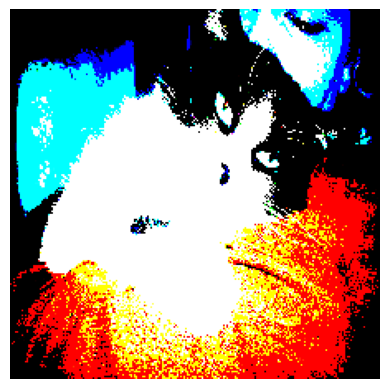

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
Giá trị dự đoán:  0


In [47]:
# 10. Dự đoán ảnh
plt.imshow(X_test[0])
plt.axis('off')  
plt.show()

y_predict = model.predict(np.expand_dims(X_test[0], axis=0))
print('Giá trị dự đoán: ', np.argmax(y_predict))

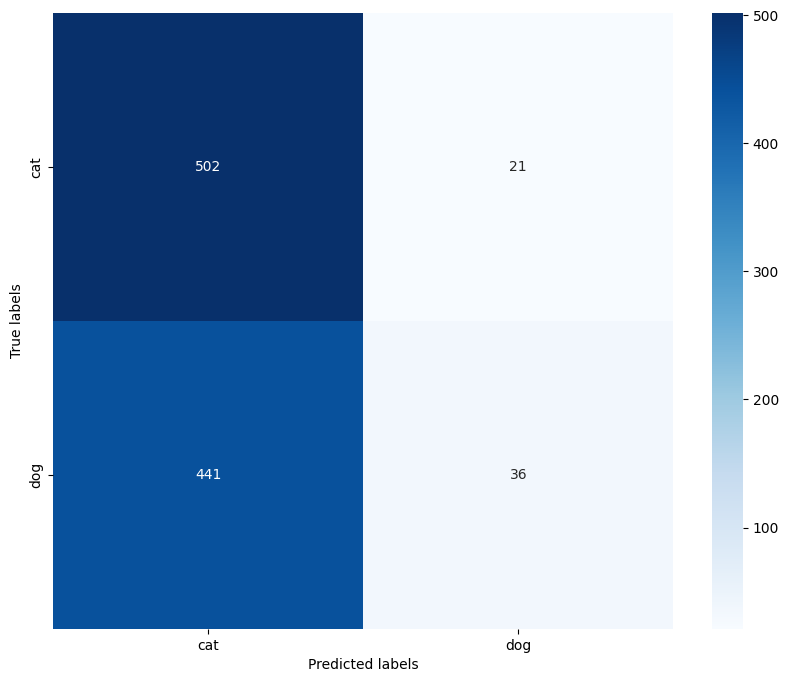

In [52]:
# Tạo ma trận nhầm lẫn
cm = confusion_matrix(y_test, preds)

# Chuyển nhãn số thành tên 
label_names = le.inverse_transform(np.unique(y_test))
label_names = [label.split('/')[-1] for label in label_names]
# Sắp xếp lại ma trận nhầm lẫn
sorted_cm = cm[np.argsort(label_names)][:, np.argsort(label_names)]

# Tạo dataframe từ ma trận nhầm lẫn đã sắp xếp lại
df_cm = pd.DataFrame(sorted_cm, index=label_names, columns=label_names)

# Vẽ ma trận nhầm lẫn
plt.figure(figsize=(10, 8))
sns.heatmap(df_cm, annot=True, cmap='Blues', fmt='g')
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.show()
